# Анализ бизнес-показателей в Яндекс.Афиша

Отделу маркетинга нужно снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.
Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года: лог сервера с данными о посещениях сайта Яндекс.Афиши, выгрузка всех заказов за этот период, статистика рекламных расходов. Выручка измеряется в условных единицах — у.е., маржинальность проекта - 100%.

Нам предстоит ответить на вопросы:

- как клиенты пользуются сервисом?
- когда делают первые покупки на сайте?
- сколько денег приносит компании каждый клиент?
- когда расходы на привлечение клиента окупаются?

Для ответов на поставленные вопросы мы рассчитали продуктовые метрики DAU, MAU, WAU, Retention Rate, ASL и число пользовательских сессий в день. Метрики электронной коммерции - время до первой покупки, среднее число покупок на покупателя и средний чек, LTV покупателей по когортам. Маркетинговые метрики - общие расходы проекта на маркетинг и расходы по источникам, СAC, ROMI в разрезе по источникам.

В заключении, определили перспективные когорты пользователей, невыгодные источники трафика, и источники, на которые следует перераспередилить бюджет.

## Загрузка и подготовка данных к анализу

Загрузка необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

Загрузка данных:

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv', parse_dates=['End Ts', 'Start Ts'])
orders = pd.read_csv('/datasets/orders_log.csv', parse_dates=['Buy Ts'])
costs = pd.read_csv('/datasets/costs.csv', parse_dates=['dt'])

### Данные о посещениях сайта

Выведем общую информацию о `visits` и 5 случайных строк:

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null datetime64[ns]
Source Id    359400 non-null int64
Start Ts     359400 non-null datetime64[ns]
Uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [4]:
visits.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid
78058,touch,2018-01-29 22:05:00,9,2018-01-29 21:57:00,1718351785901356821
297029,desktop,2017-11-11 16:38:00,3,2017-11-11 16:34:00,3115240923179478693
87925,touch,2018-02-24 17:23:00,4,2018-02-24 17:15:00,18398254835179580258
289198,desktop,2017-12-15 13:25:00,4,2017-12-15 13:08:00,8939210302602347119
79996,desktop,2018-04-03 22:53:00,5,2018-04-03 22:27:00,16262121751441932915


`visits` содержит данные о посещениях сайта Яндекс.Афиши (всего 359400 строк без пропущенных значений) и имеет структуру: 
- Uid — уникальный идентификатор пользователя,
- Device — категория устройства пользователя,
- Start Ts — дата и время начала сессии,
- End Ts — дата и время окончания сессии,
- Source Id — идентификатор источника перехода на сайт.


Приведем имена столбцов к нижнему регистру без пробелов:

In [5]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

Проверим данные на дубликаты:

In [6]:
visits.duplicated().sum()

0

Дубликатов нет, проверим, соответствуют ли сессии временному интервалу, обозначенному в тех.задании:

In [7]:
visits[(visits['start_ts'] >= '2018-06-01') |(visits['end_ts'] >= '2018-06-01')]

,device,end_ts,source_id,start_ts,uid
2330,desktop,2018-06-01 00:05:00,2,2018-05-31 23:30:00,5300693976971713685
43215,desktop,2018-06-01 00:13:00,4,2018-05-31 23:46:00,12296626599487328624
46667,desktop,2018-06-01 00:13:00,5,2018-05-31 23:48:00,1107134732939577311
154728,desktop,2018-06-01 00:09:00,2,2018-05-31 22:52:00,12484396335714047199
198329,desktop,2018-06-01 00:11:00,3,2018-05-31 23:59:00,3720373600909378583
216791,touch,2018-06-01 00:06:00,5,2018-05-31 23:45:00,9951896961656595558
263781,desktop,2018-06-01 00:25:00,1,2018-05-31 23:59:00,4906562732540547408
269213,touch,2018-06-01 00:12:00,10,2018-05-31 23:59:00,10723414689244282024
288563,touch,2018-06-01 00:01:00,4,2018-05-31 23:37:00,1094281763368510391
299620,desktop,2018-06-01 00:04:00,4,2018-05-31 23:59:00,83872787173869366


Удалим несоответствующие данные:

In [8]:
visits = visits.loc[(visits['start_ts'] < '2018-06-01') & (visits['end_ts'] < '2018-06-01')]

Данные соответствуют временному промежутку тех.задания. Вывясним, какие девайсами пользовались люди:

In [9]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

Присвоим данным с толбце `device` тип category:

In [10]:
visits['device'] = visits['device'].astype('category')
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359388 entries, 0 to 359399
Data columns (total 5 columns):
device       359388 non-null category
end_ts       359388 non-null datetime64[ns]
source_id    359388 non-null int64
start_ts     359388 non-null datetime64[ns]
uid          359388 non-null uint64
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 14.1 MB


Выясним, как распределены посещения по источникам трафика (пользователи могут заходить по разным источникам):

In [11]:
visits_by_source = visits.groupby('source_id').agg({'uid':'count'})
visits_by_source.sort_values('uid', ascending = False)

,uid
source_id,
4,101790
3,85609
5,66903
2,47624
1,34119
9,13277
10,10024
7,36
6,6


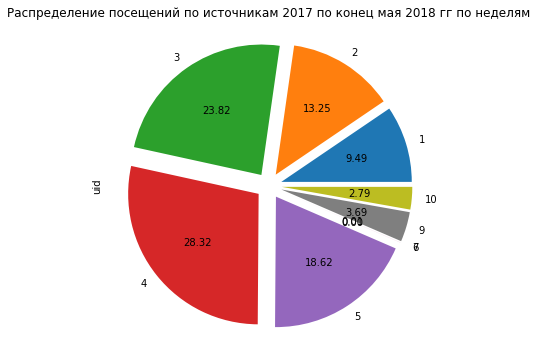

In [12]:
explode = [0.1 for _ in range(len(visits['source_id'].unique()))]
visits_by_source.plot(
    y = 'uid', 
    autopct='%.2f', 
    kind = 'pie', 
    figsize = (6, 6), 
    legend = False,
    explode = explode
)
plt.title('Распределение посещений по источникам 2017 по конец мая 2018 гг по неделям')
plt.show()

Пользователи приходят на сайт по 8 источникам траффика. Реже всего посетители приходят по 6 и 7 источникам, чаще всего - по 4, 3, 5.

### Данные о покупках

Выведем общую информацию о `orders` и 5 случайных строк:

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null datetime64[ns]
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [14]:
orders.tail(5)

,Buy Ts,Revenue,Uid
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247
50414,2018-06-01 00:02:00,3.42,83872787173869366


`orders` содержит данные о совершенных покупках (всего 50415 строк без пропущенных значений) и имеет структуру: 
- Uid — уникальный идентификатор пользователя,
- Buy Ts — дата и время заказа,
- Revenue — сумма заказа.

Приведем имена столбцов к нижнему регистру без пробелов:

In [15]:
orders.columns = ['buy_ts', 'revenue', 'uid']

Проверим данные на дубликаты и соответствие временному промежутку:

In [16]:
print('Обнаружено дубликатов', orders.duplicated().sum())
orders[orders['buy_ts'] >= '2018-06-01']

Обнаружено дубликатов 0


,buy_ts,revenue,uid
50414,2018-06-01 00:02:00,3.42,83872787173869366


Дубликатов в данных нет, строку, не соответствующую тех.заданию удалим:

In [17]:
orders = orders.drop([50414])

### Данные о расходах на маркетинг

Выведем общую информацию о `costs` и 5 случайных строк:

In [18]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [19]:
costs.sample(5)

,source_id,dt,costs
225,1,2018-01-12,54.48
870,3,2017-10-23,504.54
1081,3,2018-05-24,352.08
1556,5,2017-09-13,89.67
1299,4,2017-12-28,89.49


`costs` содержит данные о расходах на рекламные кампании (всего 2542 строки без пропущенных значений) и имеет структуру:
- source_id — идентификатор рекламного источника,
- dt — дата проведения рекламной кампании,
- costs — расходы на эту кампанию.

Проверим данные на дубликаты и соответствие временному промежутку тех.задания:

In [20]:
print('Обнаружено дубликатов', costs.duplicated().sum())
costs[costs['dt'] >= '2018-06-01']

Обнаружено дубликатов 0


,source_id,dt,costs


Дубликатов нет, все данные соответствуют временному промежутку.

**Вывод:**

Типы данных соответствуют сохраненным значениям. Пропущенных значений и дубликатов не содержат. Имена столбцов приведены к корректному виду - в нижнем регистре без пробелов. Данные,не соответствующие временному промежутку, обозначенному в задании, исключены.


## Рассчет метрик

### Продуктовые метрики

#### Рассчет DAU, WAU, MAU:

Добавим в таблицу `visits` столбцы с годом, месяцем, неделей и датой визита

In [21]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

Сгрупируем данные по временым отрезкам и посчитаем число уникальных пользователей (в день, неделю, месяц):

In [22]:
dau = visits.groupby('session_date').agg({'uid':'nunique'})
wau = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'})
mau = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'})

Вычислим среднее значение DAU, WAU, MAU за весь период. Среднее округлим и представим в виде целого числа:

In [23]:
print('Среднее значение DAU', int(dau.mean().round()))
print('Среднее значение WAU', int(wau.mean().round()))
print('Среднее значение MAU', int(mau.mean().round()))

Среднее значение DAU 908
Среднее значение WAU 5716
Среднее значение MAU 23228


Отобразм изменения метрик во времени на графиках:

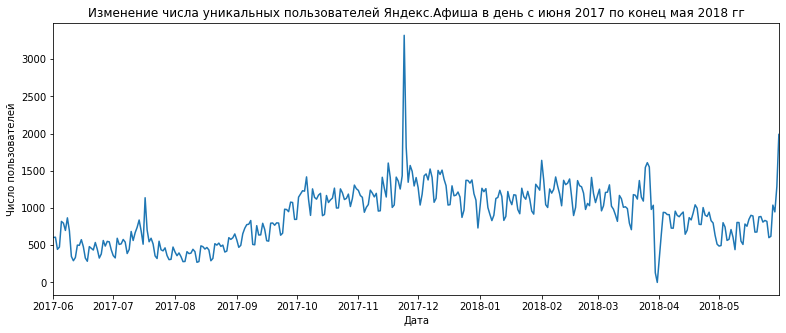

In [24]:
dau.plot(figsize=(13, 5), legend = False)
plt.title('Изменение числа уникальных пользователей Яндекс.Афиша в день с июня 2017 по конец мая 2018 гг')
plt.ylabel('Число пользователей')
plt.xlabel('Дата')
plt.show()

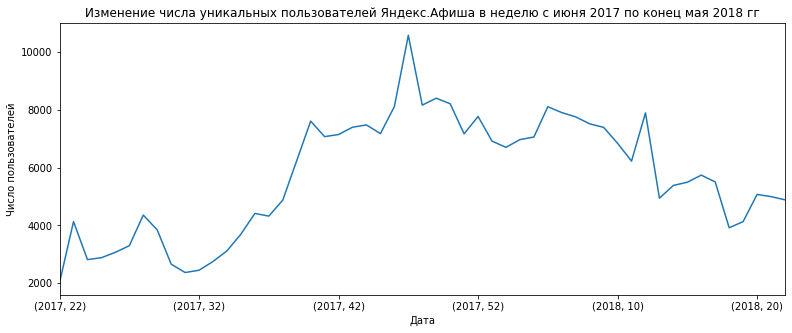

In [25]:
wau.plot(figsize=(13, 5), legend = False)
plt.title('Изменение числа уникальных пользователей Яндекс.Афиша в неделю с июня 2017 по конец мая 2018 гг')
plt.ylabel('Число пользователей')
plt.xlabel('Дата')
plt.show()

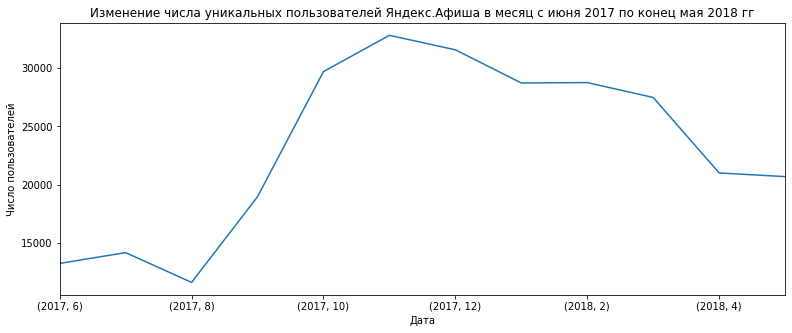

In [26]:
mau.plot(figsize=(13, 5), legend = False)
plt.title('Изменение числа уникальных пользователей Яндекс.Афиша в месяц с июня 2017 по конец мая 2018 гг')
plt.ylabel('Число пользователей')
plt.xlabel('Дата')
plt.show()

Среднии значения DAU - 908, WAU - 5716, MAU - 23228 пользователей. Для метрик DAU, WAU, MAU характерен пик в конце нояюря 2017 года. Возникает вопрос, что вызвало такой всплеск активности? Можно предположить, что пользователи начали подготвку к новогоднему сезону, но в таком случае ажиотаж продолжался бы до конца декабря. щё один варинт - открытие продажи билетов на какие-то популярные мероприятия. Но более вероятным кажется запуск короткой, но привлекательной акции. Следует уточнить этот момент у отдела маркетинга.

#### Число пользовательских сессий в день

Определим, сколько раз за день пользователи в среднем заходят на сайт.

In [27]:
sessions_per_user = visits.groupby('session_date').agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
print('В среднем, пользователи заходят на сайт {:.2f} раз в день'.format(sessions_per_user['sess_per_user'].mean()))

В среднем, пользователи заходят на сайт 1.08 раз в день


Построим график изменения метрики во времени:

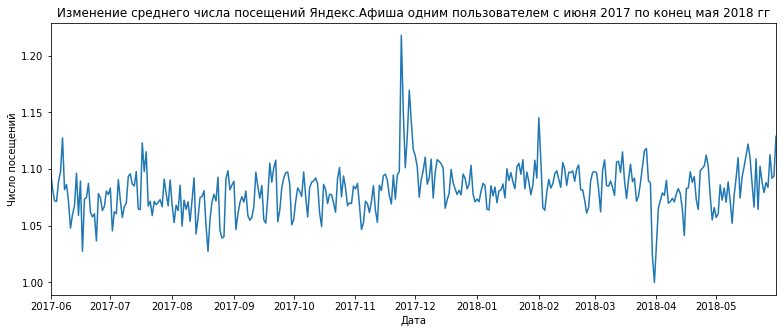

In [28]:
sessions_per_user['sess_per_user'].plot(figsize=(13, 5), legend = False)
plt.title('Изменение среднего числа посещений Яндекс.Афиша одним пользователем с июня 2017 по конец мая 2018 гг')
plt.ylabel('Число посещений')
plt.xlabel('Дата')
plt.show()

В среднем пользователи заходят на сайт Яндекс.Афиша 1 раз в день. Пик числа посещений приходится на пик числа уникальных пользователей, обнаруженный нами ранее. Что заставляло пользователей возвращаться на сайт в этот же день?

#### Продолжительность пользовательской сессии

Посчитаем ASL - среднюю продолжительность сессии пользователя на сайте

In [29]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

Оценим распределение:

In [30]:
visits['session_duration_sec'].describe()

count    359388.000000
mean        643.465703
std        1016.280993
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

Методом describe получено средняя продолжительсть пользовательской сессии - 643.5 секунд. Оценим характер распределения, чтобы определить подходящую среднюю меру.

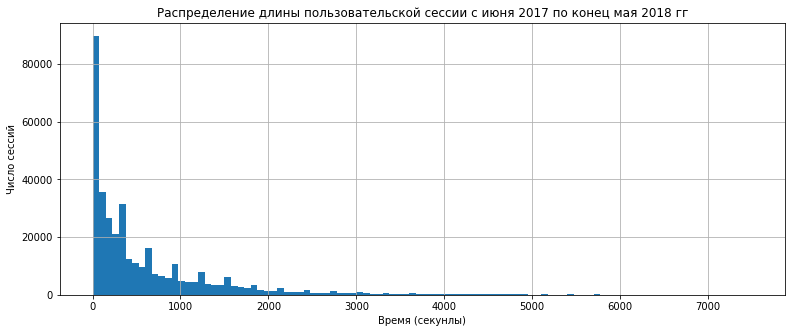

In [31]:
visits['session_duration_sec'].hist(bins=100, range=(0, 7500), figsize=(13, 5))
plt.title('Распределение длины пользовательской сессии с июня 2017 по конец мая 2018 гг')
plt.ylabel('Число сессий')
plt.xlabel('Время (секунлы)')
plt.show()

Так как распределение не нормальное, для того чтобы определить среднюю меру найдём моду

In [32]:
print('ASL пользователей Яндекс.Афиша - {:.1f} секунд'
      .format(visits.query('session_duration_sec != 0')['session_duration_sec'].mode()[0])) 

ASL пользователей Яндекс.Афиша - 60.0 секунд



   Учитывая короткое время сессии, в основном пользователи приходят на сайт на завершающем этапе покупки - оплате (после выбора мероприятия и параметров билетов на другом ресурсе, например - сайте кинотеатра или музея).

#### Рассчет Retention Rate

Для оценки коэффициента удержания разделим пользоватей на когорты по месяцу первого визита. Определим дату первого визита:

In [33]:
first_visit = visits.groupby(['uid']).agg({'start_ts':'min'})
first_visit.columns = ['first_visit']

Определим время жизни, выразим его в месяцах:

In [34]:
visits_new = visits[['uid', 'start_ts']].join(first_visit, on='uid')
visits_new['first_visit_month'] = visits_new['first_visit'].astype('datetime64[M]')
visits_new['start_ts_month'] = visits_new['start_ts'].astype('datetime64[M]')
visits_new['lifetime'] = (
    ((visits_new['start_ts_month'] - visits_new['first_visit_month']) 
     /  np.timedelta64(1, 'M')).round().astype('int')
)

Сформируем когорты, посчитаем число уникальных пользователей в определенный мясяц "жизни" когорты:

In [35]:
cohort_visits = visits_new.groupby(['first_visit_month','lifetime']).agg({'uid':'nunique'}).reset_index()

Посчитаем изначальное число уникальных пользователей в когорте:

In [36]:
initial_users_count = cohort_visits[cohort_visits['lifetime'] == 0][
    ['first_visit_month', 'uid']
]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

Посчитаем коэффициент удержания пользователей:

In [37]:
cohort_visits = cohort_visits.merge(initial_users_count,on='first_visit_month')
cohort_visits['retention'] = cohort_visits['uid']/cohort_visits['cohort_users']
cohort_visits['first_visit_month'] = cohort_visits['first_visit_month'].dt.strftime('%Y-%m')

Построим тепловую карту коэфициента удержания:

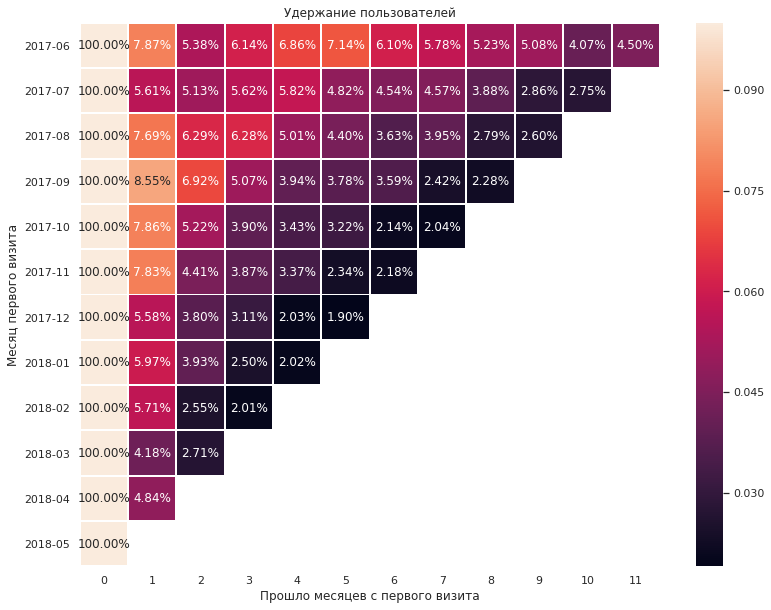

In [38]:
retention_pivot = cohort_visits.pivot_table(
    index='first_visit_month',
    columns='lifetime',
    values='retention',
    aggfunc='sum',
)

sns.set(style='white')
plt.figure(figsize=(13, 10))
plt.title('Удержание пользователей')
sns.heatmap(retention_pivot, 
            annot=True, fmt='.2%', 
            linewidths=1, 
            linecolor='white',
            vmax='0.1'
           )
plt.ylabel('Месяц первого визита')
plt.xlabel('Прошло месяцев с первого визита')
plt.show()

In [85]:
print('Cредний Retention Rate на второй месяц жизни когорт: {:.2%}'.format(retention_pivot.mean()[1]))

Cредний Retention Rate на второй месяц жизни когорт: 6.52%


Как мы видим, коэфициент удержания пользователей низкий - уже через месяц возвращается менее 10% пользователей когорты, а для более "юных" когорт показатель еще ниже - ~5%. Средний Retention Rate на второй месяц жизни когорт: 4.28%. Объяснить данное явление можно с нескольких сторон:

- средний пользователь не заинтересован в ежемесячном посещении мероприятий и покупке билетов
- пользователь не доволен опытом взаимодейсвтия с сервисом Яндекс.Афиша
- увеличение числа конкурентов среди сервисов, подобных Яндекс.Афиша

**Вывод:**

Посчитаны следующие продуктовые метрики, определены средние значения:

- Среднее значение DAU - 908 пользователей в день
- Среднее значение WAU - 5716 пользователей в неделю
- Среднее значение MAU - 23228 пользователей в месяц
- Среднее число пользовательских сессий - 1.02 в день
- ASL пользователей Яндекс.Афиша - 60.0 секунд

Учитывая короткое время сессии, в основном пользователи приходят на сайт на завершающем этапе покупки - оплате (после выбора мероприятия и параметров билетов на другом ресурсе, например - сайте кинотеатра или музея).

Обнаружен пик, характерный для DAU, WAU, MAU и числа пользовательских сессий в конце ноября 2017 года.

Для рассчета коэффициента удержания пользователи разбиты на месячные когорты (в зависимости от месяца первого визита). Результаты изменения Retention Rate представлены в виде тепловой карты. Коэфициент удержания пользователей низкий - уже через месяц возвращается менее 10% пользователей когорты, а для более "юных" когорт показатель еще ниже - ~5%. Средний Retention Rate на второй месяц жизни когорт: 4.63%. Объяснить данное явление можно с нескольких сторон:

- средний пользователь не заинтересован в ежемесячном посещении мероприятий и покупке билетов
- пользователь не доволен опытом взаимодейсвтия с сервисом Яндекс.Афиша
- увеличение числа конкурентов среди сервисов, подобных Яндекс.Афиша


<div class="alert alert-block alert-success">
Комментарий ревьюера v. 1:
    
Отлично, итог анализа подведён.
</div>

### Метрики электронной коммерции

#### Время от первого визита до покупки

Узнаем, сколько проходит времени между первым визитом пользователя и его первой покупкой на сервисе Яндекс.Афиша. Таблица с данными о первом визите у нас уже есть, сформируем данные о первой покупке пользователей:

In [40]:
first_order = orders.groupby(['uid']).agg({'buy_ts':'min'})
first_order.columns = ['first_order']
first_order = first_order.join(first_visit, on = 'uid')
first_order.sample(5)

,first_order,first_visit
uid,,
13603928627701595488,2018-03-21 16:29:00,2018-03-02 18:00:00
1492177727616175458,2017-10-07 10:17:00,2017-10-07 10:12:00
8583231174237368466,2018-01-02 16:13:00,2018-01-02 16:13:00
13254234980882699364,2017-12-29 00:06:00,2017-11-12 19:59:00
11750949012624899395,2018-02-26 17:21:00,2018-02-09 17:45:00


Сформируем столбец с времени между первой покупкой и первым визитом пользователя, результат выразим в секундах:

In [41]:
first_order['time_before_purchase'] = (first_order['first_order'] - first_order['first_visit']).dt.seconds / 1

Оценим характер распределения для выбора среднеей меры:

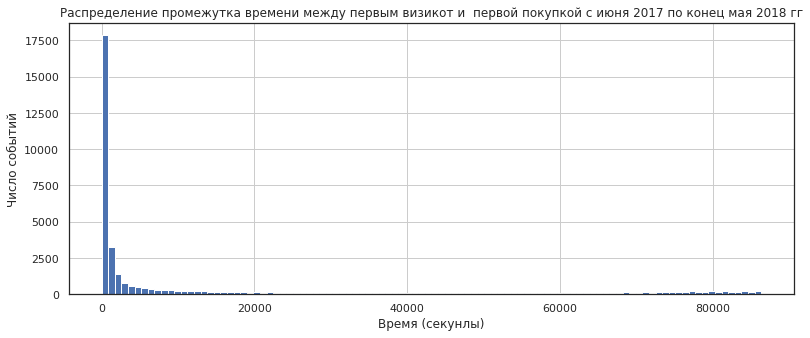

In [42]:
first_order['time_before_purchase'].hist(bins=100, figsize=(13, 5))
plt.title('Распределение промежутка времени между первым визикот и  первой покупкой с июня 2017 по конец мая 2018 гг')
plt.ylabel('Число событий')
plt.xlabel('Время (секунлы)')
plt.show()

Так как распределение не нормальное, для того чтобы определить среднюю меру найдём моду

In [43]:
print(
    'В среднем, от первого визита до покупки пользователи проводят на сайте {} секунд'
    .format(first_order['time_before_purchase'].mode()[0])
)

В среднем, от первого визита до покупки пользователи проводят на сайте 60.0 секунд


Пользователи приходят на сайт, быстро покупают билеты и быстро забывают о сервисе.

#### Среднее число покупок на покупателя

Определим среднее число покупок на одного покупателя за 6 месяцев, применив когортный анализ.

Разделим пользователей на месячные когорты в зависимости от даты первой покупки. Определим время жизни, выразим его в месяцах:

In [44]:
orders_new = orders[['uid', 'buy_ts']].join(first_order['first_order'], on='uid')
orders_new['first_order_month'] = orders_new['first_order'].astype('datetime64[M]')
orders_new['buy_ts_month'] = orders_new['buy_ts'].astype('datetime64[M]')
orders_new['lifetime'] = (
    ((orders_new['buy_ts_month'] - orders_new['first_order_month']) 
     /  np.timedelta64(1, 'M')).round().astype('int')
)

Сформируем когорты, посчитаем число покупок и уникальных пользователей в определенный мясяц "жизни" когорты:

In [45]:
cohort_orders = orders_new.groupby(['first_order_month','lifetime']).agg({'uid':['count', 'nunique']}).reset_index()
cohort_orders.columns = ['first_order_month', 'lifetime', 'purchases', 'uid']
cohort_orders['first_order_month'] = cohort_orders['first_order_month'].dt.strftime('%Y-%m')

Посчитаем число покупок на пользователя:

In [46]:
cohort_orders['purchases_per_user'] = cohort_orders['purchases']/cohort_orders['uid']

Построим тепловую карту:

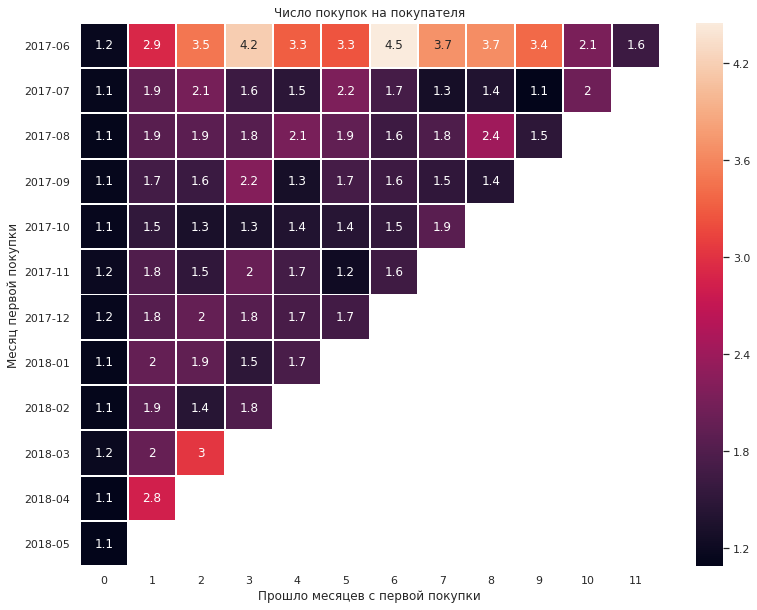

In [47]:
purchases_pivot = cohort_orders.pivot_table(
    index='first_order_month',
    columns='lifetime',
    values='purchases_per_user'
)

sns.set(style='white')
plt.figure(figsize=(13, 10))
plt.title('Число покупок на покупателя')
sns.heatmap(purchases_pivot, annot=True, linewidths=1, linecolor='white')
plt.ylabel('Месяц первой покупки')
plt.xlabel('Прошло месяцев с первой покупки')
plt.show()

Покупатели в первый месяц совершают повторные покупки не часто. За исключением майской когорты 2018 года, начиная со второго месяца число заказов на одного покупателя увеличивается (мы помним, что в это время "жизни" когорты остаётся менее 10 % от изначельного количества пользователей).

Для рассчета среднего числа покупок на покупателя за 6 месяцев будем учитывать первые 6 месяцев жизни когорты и только те когорты, что существуют не меньше 6 месяцев:

In [48]:
cohorts_old = purchases_pivot.loc[:, '0':'5'].dropna().T
cohorts_old

first_order_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
lifetime,,,,,,,
0,1.163618,1.136765,1.118978,1.136381,1.143779,1.179368,1.152635
1,2.901639,1.923077,1.862069,1.684615,1.524272,1.788288,1.849315
2,3.480000,2.105263,1.886792,1.610000,1.317073,1.516667,1.961165
3,4.185185,1.625000,1.840909,2.216216,1.326087,1.990566,1.845361
4,3.318182,1.469388,2.125000,1.288462,1.387097,1.679012,1.720000
5,3.253731,2.157895,1.937500,1.703125,1.430556,1.229167,1.666667


In [49]:
cohorts_old.mean()

first_order_month
2017-06    3.050393
2017-07    1.736231
2017-08    1.795208
2017-09    1.606467
2017-10    1.354811
2017-11    1.563845
2017-12    1.699190
dtype: float64

Лучшие показатели за 6 месяцев у первой когорты - 3 покупки в месяц. На покупателя из когорты октября 2017 в среднем приходится 1.35 покупки в месяц. В остальных когортах показатель лежит в пределах от 1.56 до 1.8. Повторные покупки совершаются, но редко.

#### Средний чек

Посмотрим, как менялся средний чек покупателей Яндекс.Афиша.


Выделим месяц покупки:

In [50]:
orders['buy_year']  = orders['buy_ts'].dt.year
orders['buy_month'] = orders['buy_ts'].dt.month
orders['buy_week']  = orders['buy_ts'].dt.week
orders['buy_date'] = orders['buy_ts'].dt.date

Сгруппируем данные по дате совершения покупки

In [51]:
average_revenu_date = orders.groupby('buy_date').agg({'revenue':['sum','count']})
average_revenu_date.columns = ['revenue_total', 'purchase']
average_revenu_date['average_revenu'] = average_revenu_date['revenue_total'] / average_revenu_date['purchase']
print('Средний чек {:.0f} у.е.'.format(average_revenu_date['average_revenu'].mean()))

Средний чек 5 у.е.


In [52]:
average_revenu_week = orders.groupby(['buy_year', 'buy_week']).agg({'revenue':['sum','count']})
average_revenu_week.columns = ['revenue_total', 'purchase']
average_revenu_week['average_revenu'] = average_revenu_week['revenue_total'] / average_revenu_week['purchase']
print('Средний чек {:.0f} у.е.'.format(average_revenu_week['average_revenu'].mean()))

Средний чек 5 у.е.


In [53]:
average_revenu_month = orders.groupby(['buy_year', 'buy_month']).agg({'revenue':['sum','count']})
average_revenu_month.columns = ['revenue_total', 'purchase']
average_revenu_month['average_revenu'] = average_revenu_month['revenue_total'] / average_revenu_month['purchase']
print('Средний чек {:.0f} у.е.'.format(average_revenu_month['average_revenu'].mean()))

Средний чек 5 у.е.


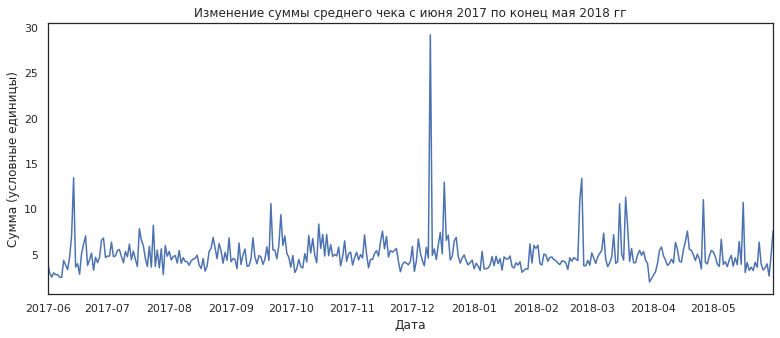

In [54]:
average_revenu_date['average_revenu'].plot(figsize=(13, 5), legend = False)
plt.title('Изменение суммы среднего чека с июня 2017 по конец мая 2018 гг')
plt.ylabel('Сумма (условные единицы)')
plt.xlabel('Дата')
plt.show()

На графикеи зменения суммы среднего чека по дням видны колебания в районе отметки 5 у.е. Выделяется пик в начале декабря - возможно кто-то совершил большую покупку в предверии новогодних праздников.

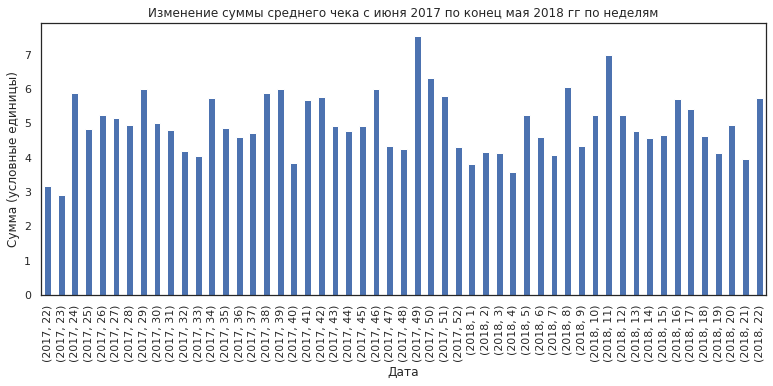

In [55]:
average_revenu_week['average_revenu'].plot(kind = 'bar', figsize=(13, 5), legend = False)
plt.title('Изменение суммы среднего чека с июня 2017 по конец мая 2018 гг по неделям')
plt.ylabel('Сумма (условные единицы)')
plt.xlabel('Дата')
plt.show()

При визуализации изменения среднего чека по неделям, декабрьский пик заметен, но уже не так выделяется. Ещё один заметный пик в середине марта. Возможно была запущена удачная рекламная кампания. 

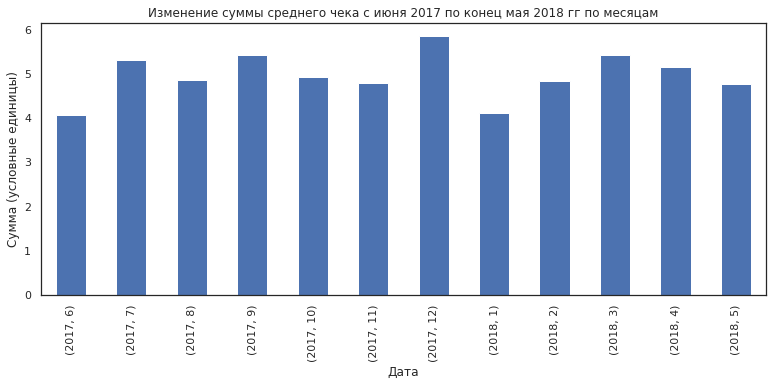

In [56]:
average_revenu_month['average_revenu'].plot(kind = 'bar', figsize=(13, 5), legend = False)
plt.title('Изменение суммы среднего чека с июня 2017 по конец мая 2018 гг по месяцам')
plt.ylabel('Сумма (условные единицы)')
plt.xlabel('Дата')
plt.show()

В месячном разрезе, декабрь остаётся лидером по величине среднего чека (наблюдаемый ранее пик оказывает большое влияние).  


   Для всех графиков характерно падение среднего чека в январе и начале лета. Вероятно, в большей степени это связано с отпусками. Летнее падение можно объяснить завершением театрального сезона и сокращением числа премьер в кинотеатрах.

#### Расссчет LTV

In [57]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

In [58]:
first_order = orders.groupby('uid').agg({'buy_ts':'min'}).reset_index()
first_order['buy_ts'] = first_order['buy_ts'].astype('datetime64[M]')
first_order.columns = ['uid', 'first_order_month']

In [59]:
cohort_sizes = (
    first_order.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)

cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [60]:
orders_new = pd.merge(orders, first_order, on='uid')
cohorts_orders = (
    orders_new.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
print(cohorts_orders)

   first_order_month order_month   revenue
0         2017-06-01  2017-06-01   9557.49
1         2017-06-01  2017-07-01    981.82
2         2017-06-01  2017-08-01    885.34
3         2017-06-01  2017-09-01   1931.30
4         2017-06-01  2017-10-01   2068.58
..               ...         ...       ...
73        2018-03-01  2018-04-01   1063.05
74        2018-03-01  2018-05-01   1114.87
75        2018-04-01  2018-04-01  10600.69
76        2018-04-01  2018-05-01   1209.92
77        2018-05-01  2018-05-01  13925.76

[78 rows x 3 columns]


In [61]:
report = pd.merge(cohort_sizes, cohorts_orders, on='first_order_month')
report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [62]:
margin_rate = 1

report['gp'] = report['revenue'] * margin_rate
report['lifetime'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['lifetime'] = report['lifetime'].round().astype('int')
print(report.head()) 

  first_order_month  n_buyers order_month  revenue       gp  lifetime
0        2017-06-01      2023  2017-06-01  9557.49  9557.49         0
1        2017-06-01      2023  2017-07-01   981.82   981.82         1
2        2017-06-01      2023  2017-08-01   885.34   885.34         2
3        2017-06-01      2023  2017-09-01  1931.30  1931.30         3
4        2017-06-01      2023  2017-10-01  2068.58  2068.58         4


In [63]:
report['ltv'] = report['gp'] / report['n_buyers']
report

,first_order_month,n_buyers,order_month,revenue,gp,lifetime,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531
...,...,...,...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05,1063.05,1,0.300892
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2,0.315559
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0,4.657597
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1,0.531599


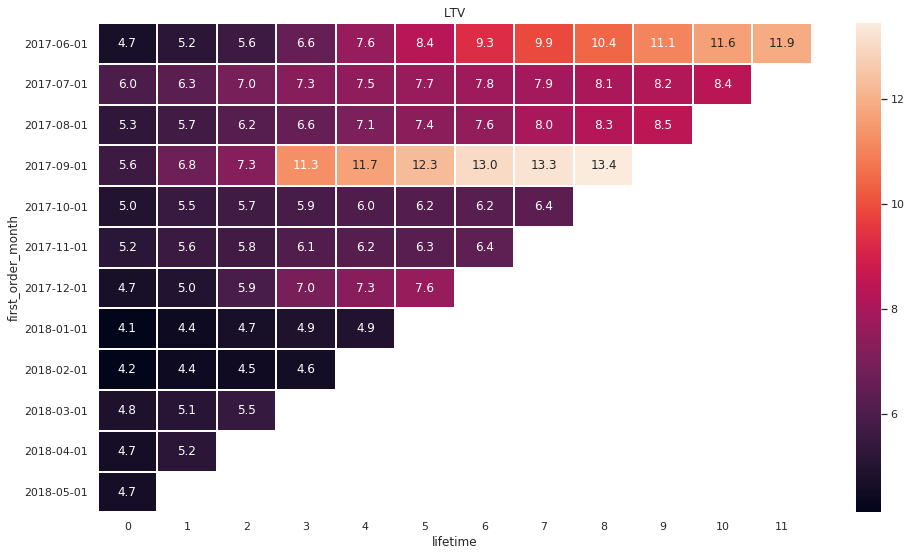

In [64]:
ltv = report.pivot_table(
    index='first_order_month', 
    columns='lifetime', 
    values='ltv', 
    aggfunc='mean'
).cumsum(axis=1)

sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 9))
plt.title('LTV')
ax = sns.heatmap(ltv, annot=True, fmt='.1f', linewidths=1, linecolor='white')
ax.set_yticklabels(ltv.index.date)
plt.show() 

Найдём ценнность клиентов спустя полгода:

In [65]:
cohorts_ltv_6_month = ltv.loc[:, 5].dropna()
print(cohorts_ltv_6_month)
print('Среднее значение LTV за 6 месяцев {:.1f} у.е.'.format(cohorts_ltv_6_month.mean()))

first_order_month
2017-06-01     8.360084
2017-07-01     7.660775
2017-08-01     7.375861
2017-09-01    12.306463
2017-10-01     6.159956
2017-11-01     6.280316
2017-12-01     7.639913
Name: 5, dtype: float64
Среднее значение LTV за 6 месяцев 8.0 у.е.


**Вывод:**
    
Среднее время, которое покупатели проводят на сайте до совершения покупки, составляет 60 секунд. 

Среди когорт, "живущих" более 5 месяцев, за 6 месяцев среднее число покупок на одного пользователя максимально для первой когорты (2017-06) - 3 покупки на человека в месяц, а минимально для пятой когорты когорты (2017-10) - всего 1,35 покупкив месяц на покупателя. У остальных когорт результат лучше и лежит в диапазоне от 1.56 до 1.8.

Средний чек - 5 условных единиц.

Что касается LTV, наибольший показатель за 6 месяцев у четвертой когорты (2017-09) - 12.3 у.е. Первая когорта имеет LTV 8.3 у.е, самый низкий показатель в пятой когорте - 6.2 у.е. Среднее значение LTV за 6 месяцев 8 у.е.

### Маркетинговые метрики

#### Расходы на маркетинг

In [66]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [67]:
source_cost = costs.groupby('source_id').agg({'costs':'sum'})

In [68]:
print('Общая сумма расходов на рекламные кампании {:.2f} у.е.'.format(source_cost['costs'].sum()))

Общая сумма расходов на рекламные кампании 329131.62 у.е.


Посмотрим, как распределились расходы по источникам:

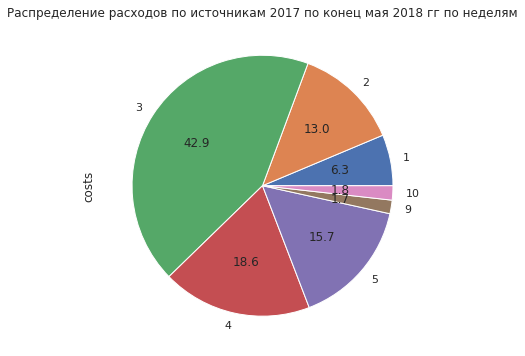

In [69]:
source_cost.plot(y = 'costs', autopct='%.1f', kind = 'pie', figsize = (6, 6), legend = False)
plt.title('Распределение расходов по источникам 2017 по конец мая 2018 гг по неделям')
plt.show()


Маркетологи делают упор на 3 источник трафика - более 40% всего бюджета. Меньшие доли бюджета выделены источникам 2, 4 и 5 (от 13 до 18.6 % бюджета). Ещё меньше вложено в источник 6 - 6.3%. В рекламу по источникам 9 и 10 почти не вкладываются (менее 2% по каждому). При этом мы помним, что чаще всего пользователи приходили по 4 источнику.

Выясним, как менялись траты на маркетинг помесячно:

In [70]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs['month_source'] = costs['month'].dt.strftime('%Y-%m')

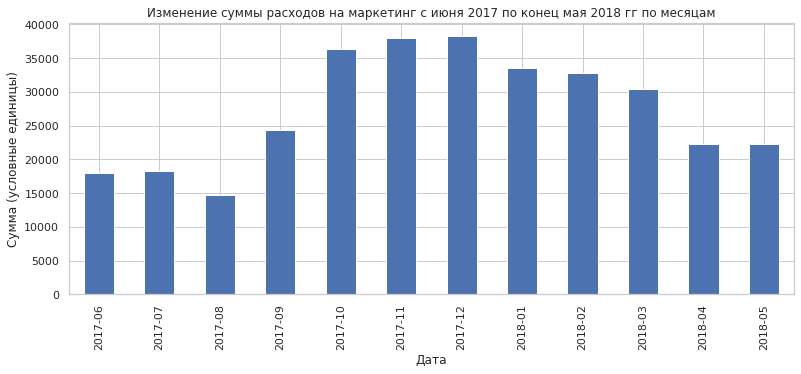

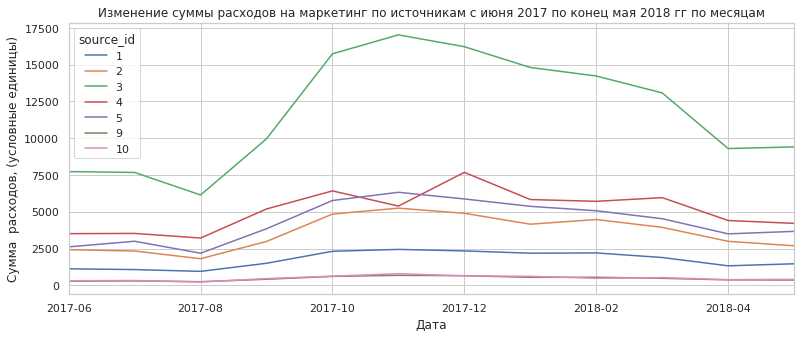

In [71]:
costs_by_month = costs.groupby(['month_source']).agg({'costs':'sum'})
costs_by_month.plot( 
    kind = 'bar', 
    figsize=(13, 5), 
    legend = False
)
plt.title('Изменение суммы расходов на маркетинг с июня 2017 по конец мая 2018 гг по месяцам')
plt.ylabel('Сумма (условные единицы)')
plt.xlabel('Дата')
plt.show()

source_by_month = costs.pivot_table(
    index = 'month_source',
    columns = 'source_id',
    values = 'costs',
    aggfunc = 'sum'
)
source_by_month.plot( 
    figsize=(13, 5)
)
plt.title('Изменение суммы расходов на маркетинг по источникам с июня 2017 по конец мая 2018 гг по месяцам')
plt.ylabel('Сумма  расходов, (условные единицы)')
plt.xlabel('Дата')
plt.show()

Наибольшие расходы приходятся на последние три месяца 2017 года. Из графика распределения расходов по месяцам видно, что маркетологи делают упор на источник "3". Стоит отметить, что наибольшее влияние на изменение сумм маркетинговых расходов вносит бюджет третьего источника - динамика расходов по этому источнику почти полностью совпадает с динамикой общих расходов.  В декабре дополнительное влияние оказывает источник 4, бюджет которого был увеличен.

#### CAC

Рассчитаем средний CAC на одного покупателя для всего проекта. Сгруппируем данные о расходах по месяцам кампаний:

In [72]:
costs_by_month = costs_by_month.reset_index()

In [73]:
cohort_sizes['month_source'] = cohort_sizes['first_order_month'].dt.strftime('%Y-%m')


In [74]:
cac_month = pd.merge(costs_by_month, cohort_sizes, on='month_source')


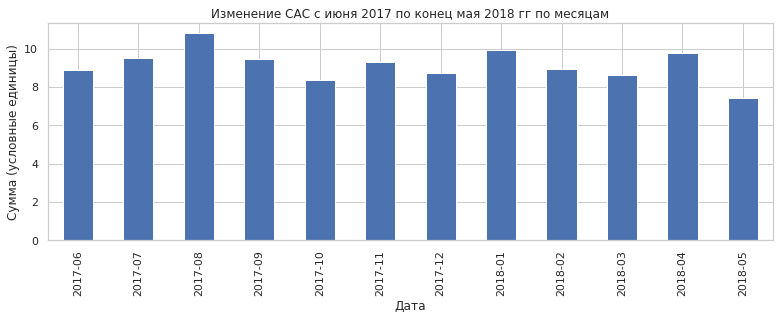

In [75]:
cac_month['cac'] = cac_month['costs'] / cac_month['n_buyers']
cac_month.plot(
    x = 'month_source',
    y = 'cac',
    kind = 'bar', 
    figsize=(13, 4), 
    legend = False
)
plt.title('Изменение САС с июня 2017 по конец мая 2018 гг по месяцам')
plt.ylabel('Сумма (условные единицы)')
plt.xlabel('Дата')
plt.show()

Без учета распределения по источникам, самый высокий показатель CAC для покупателей в 2017 году - более 10 у.е. Посчитаем CAC для всего проекта:

In [76]:
cac_month['cac'].describe()

count    12.000000
mean      9.147357
std       0.855737
min       7.437841
25%       8.708584
50%       9.125814
75%       9.562421
max      10.796015
Name: cac, dtype: float64

Мы помним, что среднее LTV за 6 месяцев - 8 у.е.

Среднее и медианное значение CAC - 9.1 у.е. (плохой показатель для ROMI за 6 месяцев). Но в мае 2018 СAC имеет минимальное значение за год - 7.4 у.е. 

Посмотрим, чему равно CAC для каждого источника трафика.

In [77]:
visits = pd.merge(visits, first_visit.reset_index(), on = 'uid')
new_visits = visits.query('start_ts == first_visit')

In [78]:
customers_by_source = (
    orders.merge(new_visits, on='uid', how='inner')
    .groupby('source_id').agg({'uid':'nunique'})
    .reset_index()
    .rename(columns={'uid':'customers'})
)
customers_by_source

,source_id,customers
0,1,2899
1,2,3506
2,3,10473
3,4,10295
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [79]:
cac_source = pd.merge(customers_by_source, source_cost.reset_index(), on = 'source_id')
cac_source['cac'] = round(cac_source['costs'] / cac_source['customers'], 2)
cac_source.sort_values('cac', ascending = False)

,source_id,customers,costs,cac
2,3,10473,141321.63,13.49
1,2,3506,42806.04,12.21
4,5,6931,51757.10,7.47
0,1,2899,20833.27,7.19
3,4,10295,61073.60,5.93
5,9,1088,5517.49,5.07
6,10,1329,5822.49,4.38


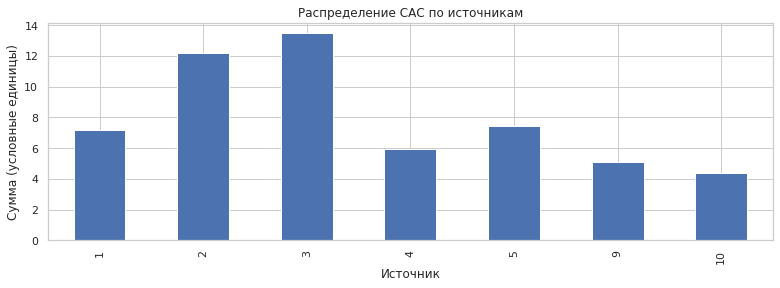

In [80]:
cac_source.plot(
    x = 'source_id',
    y = 'cac',
    kind = 'bar', 
    figsize=(13, 4), 
    legend = False
)
plt.title('Распределение САС по источникам')
plt.ylabel('Сумма (условные единицы)')
plt.xlabel('Источник')
plt.show()

Как и в случае с бюджетом, источник 3 вносит существенное влияние на CAC всего проекта. При этом число покупателей сравнимо с числом покупателей по источнику 4, а его CAC меньше в 2.3 раза.Источник 2 также выглядит слишком дорогим.

#### ROMI

In [81]:
orders_new = (orders_new.merge(new_visits, on='uid', how='inner'))
orders_new = orders_new[['buy_ts', 'revenue', 'uid', 'buy_year', 'buy_month',
       'buy_date','first_order_month','order_month','source_id']]

Сформируем список источников:

In [82]:
source_list = sorted(orders_new['source_id'].unique())
source_list

[1, 2, 3, 4, 5, 7, 9, 10]

В цикле сформируем таблицы ROI для каждого источника по когортам и посчитаем среднее время окупаемости источника:

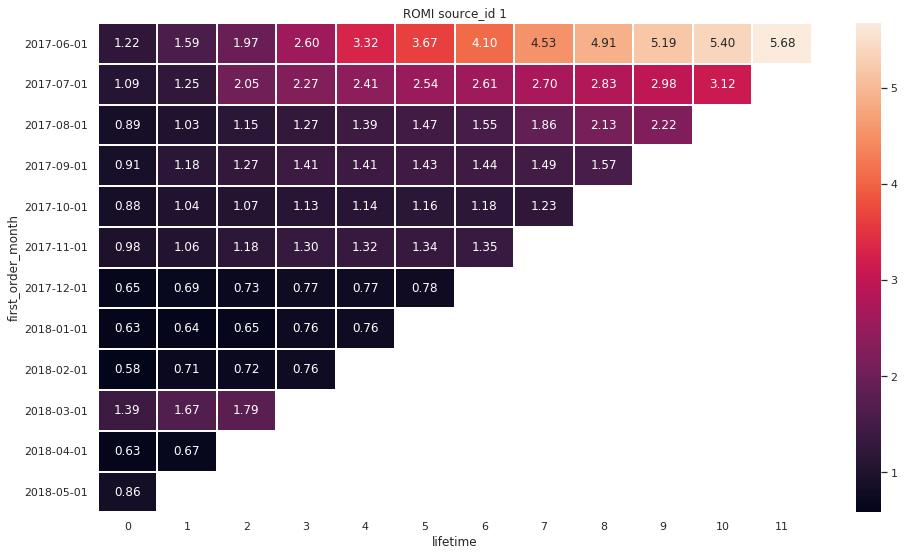

lifetime
0     0.892768
1     1.048742
2     1.258675
3     1.363425
4     1.565990
5     1.768576
6     2.038114
7     2.362370
8     2.860597
9     3.462846
10    4.256256
11    5.679045
dtype: float64


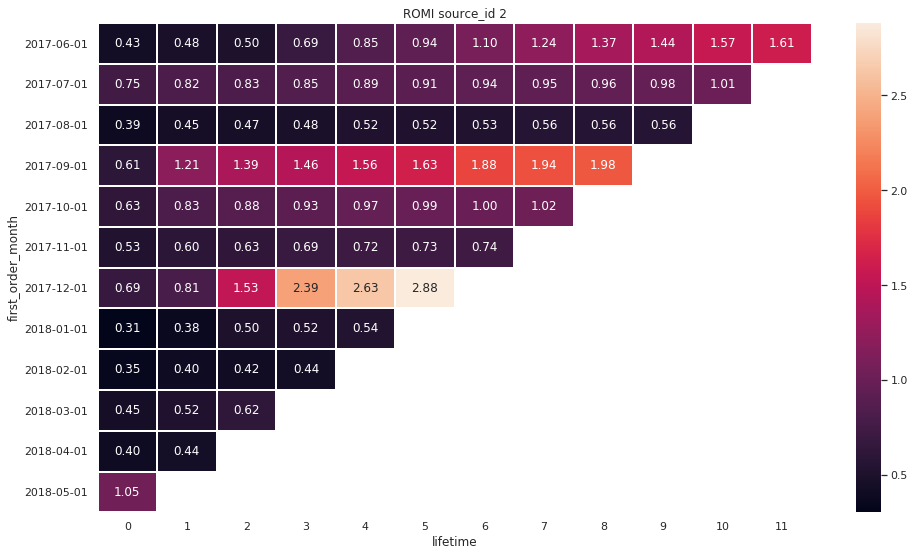

lifetime
0     0.549286
1     0.630051
2     0.777428
3     0.939189
4     1.085749
5     1.229496
6     1.029998
7     1.140317
8     1.215401
9     0.994079
10    1.290747
11    1.612957
dtype: float64


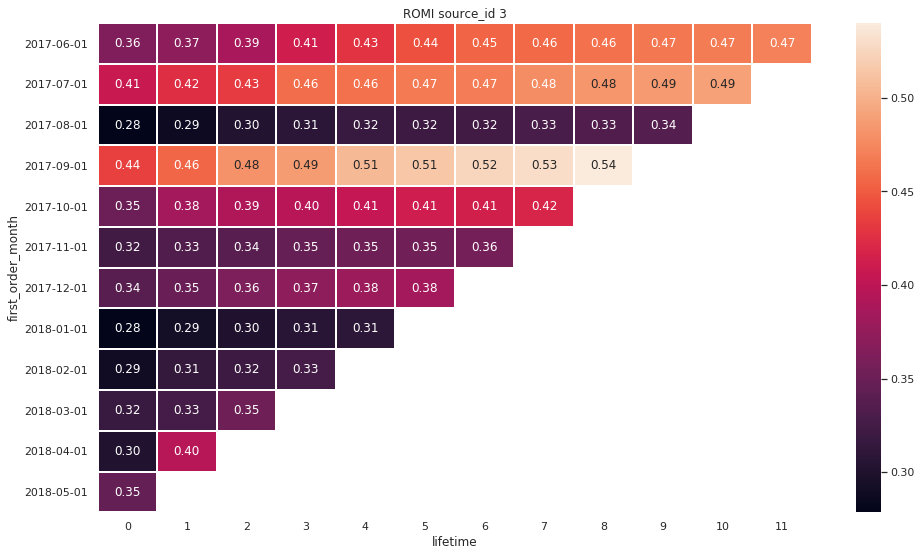

lifetime
0     0.336151
1     0.357750
2     0.367152
3     0.379767
4     0.394988
5     0.413851
6     0.423732
7     0.442706
8     0.454574
9     0.429613
10    0.479128
11    0.470834
dtype: float64


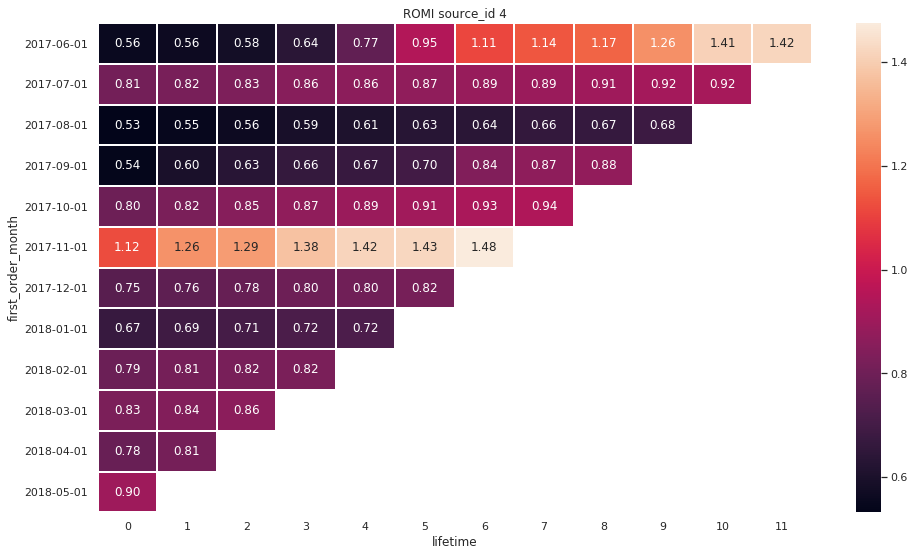

lifetime
0     0.757409
1     0.776915
2     0.791630
3     0.814921
4     0.843845
5     0.900297
6     0.980375
7     0.900496
8     0.904477
9     0.952753
10    1.165144
11    1.420471
dtype: float64


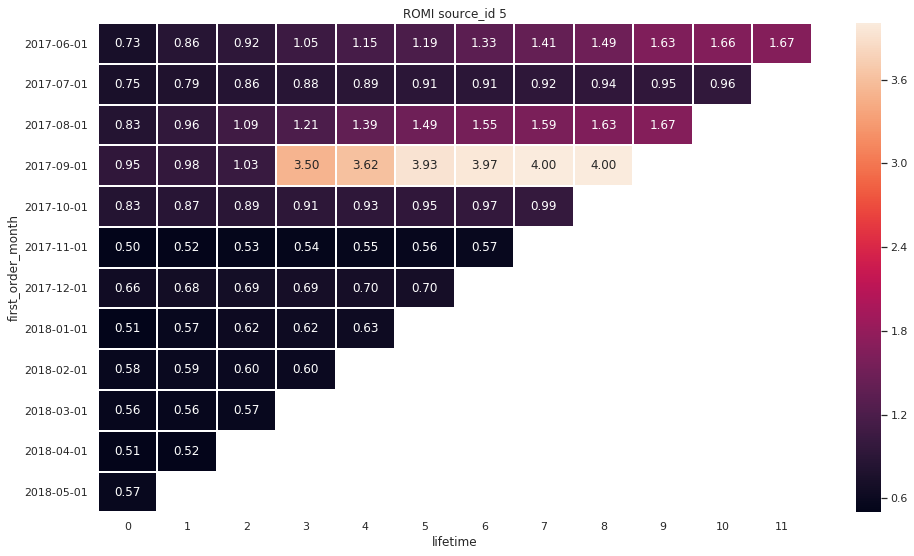

lifetime
0     0.664923
1     0.718179
2     0.779610
3     1.111582
4     1.231647
5     1.387731
6     1.549131
7     1.783598
8     2.016601
9     1.415622
10    1.306381
11    1.673333
dtype: float64
Нельзя построить тепловую карту


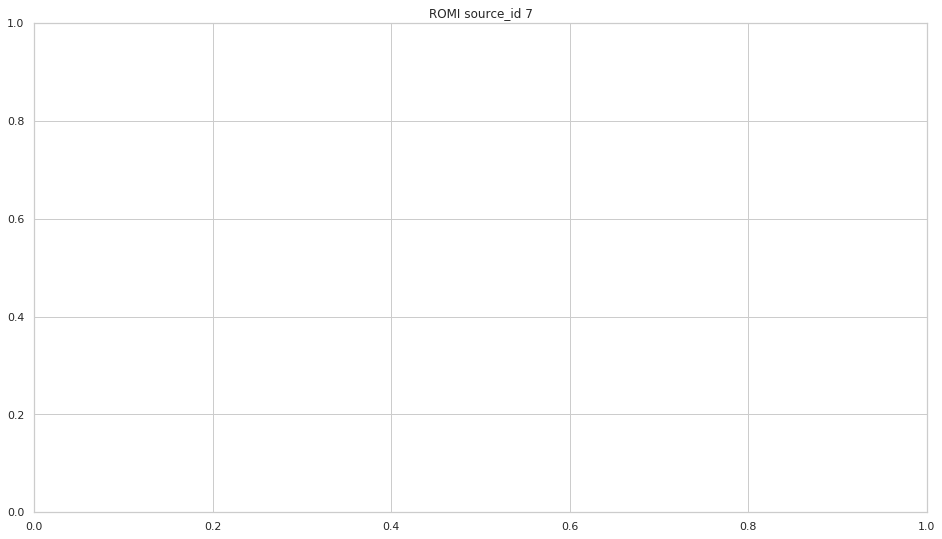

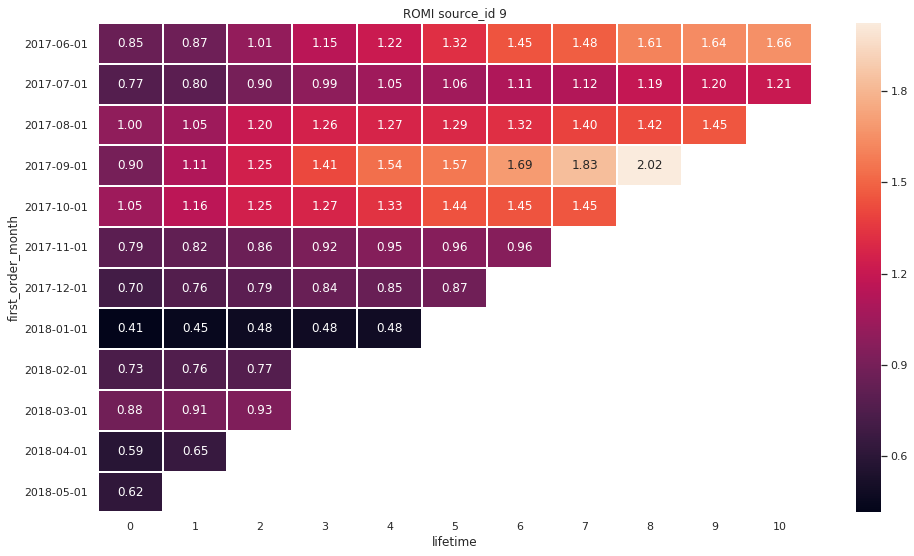

lifetime
0     0.774013
1     0.847641
2     0.943664
3     1.041018
4     1.086613
5     1.216218
6     1.331051
7     1.455936
8     1.559885
9     1.428569
10    1.432871
dtype: float64


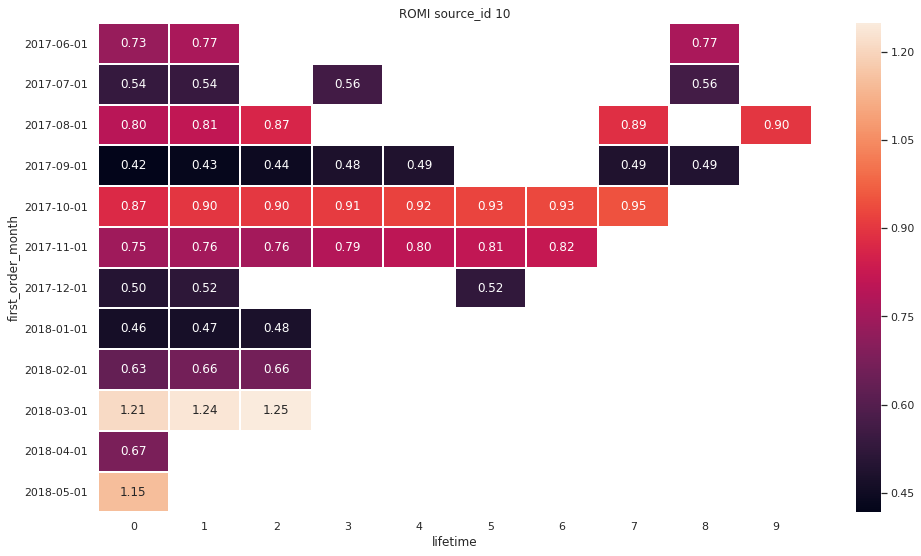

lifetime
0    0.727377
1    0.708520
2    0.765743
3    0.685040
4    0.737312
5    0.754071
6    0.876620
7    0.773929
8    0.608024
9    0.899557
dtype: float64


In [83]:
for source in source_list:
    orders_sourse = orders_new.query('source_id == @source')
    cohort_sizes = (
    first_order.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index())
    
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
    
    cohorts_orders = (
    orders_sourse.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'}).reset_index())
    
    report = pd.merge(cohort_sizes, cohorts_orders, on='first_order_month')
        
    report['gp'] = report['revenue'] * margin_rate
    report['lifetime'] = (
    report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
    report['lifetime'] = report['lifetime'].round().astype('int')
    report['ltv'] = report['gp'] / report['n_buyers']
    
    cost_sousce = costs.query('source_id == @source')
    monthly_costs = cost_sousce.groupby('month').agg({'costs':'sum'})
    
    report = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
    report['cac'] = report['costs'] / report['n_buyers']
    report['romi'] = report['ltv'] / report['cac']
    
    
    romi = report.pivot_table(
    index='first_order_month', 
    columns='lifetime', 
    values='romi', 
    aggfunc='mean'
    ).cumsum(axis=1)
       
    try:
        sns.set(style = 'whitegrid')
        plt.figure(figsize = (16, 9))
        plt.title('ROMI source_id {}'.format(source))
        ax = sns.heatmap(romi, annot=True, fmt='.2f', linewidths=1, linecolor='white')
        ax.set_yticklabels(romi.index.date)
        plt.show()
        print(romi.mean(axis=0))
    
    
    except:
        print('Нельзя построить тепловую карту')  
    

Выясним причину, по котрой не удалось построить тепловую карту для источника 7:

In [84]:
orders_new.groupby('source_id').agg({'uid':'count'})

,uid
source_id,
1,5223
2,6392
3,13289
4,12894
5,9406
7,1
9,1647
10,1562


Число покупателей, пришедших по этому источнику трафика ничтожно мало - 1. 

Проанализируем источники трафика:
- 1: в среднем окупается уже в момент рождения когорты, при более детальном анализе хорошие показатели у когорт 2017-06, 2017-07; перспективная когорта - 2018-03
- 2: в среднем когорты начинают приносить прибыль на 5 месяц жизни, наиболее перспективная для источника когорта 2017-09
- 3: самый дорогой из источников, ни одна из когорт не окупила затраты на привлечение покупателей
- 4: когорта 2017-11 окупилась в первый месяц, но в среднем когорты окупаются только через 10 месяцев
- 5: в среднем когорты начинают приносить прибыль на 4 месяц жизни, но при более детальном анализе видно, что существенный вклад на 4 месяце вносит когорта 2017-09, но более молодые когорты и когорта 2017-07 не вышли на уровень окупаемости маркетинговых затрат.
- 9: к 4 месяцу когорты в среднем окупаются, при детальном анализе окупаются когорты 2017-10и старше, когорта 2018-03 находится на третьем месяце жизни и имеет ROMI 0.99, что позволяет считать её перспективной
- 10: выглядит как нестабильный источник трафика с плохой окупаемостью.

## Выводы и рекомендации

Посчитаны следующие продуктовые метрики, определены средние значения:

- Среднее значение DAU - 908 пользователей в день
- Среднее значение WAU - 5716 пользователей в неделю
- Среднее значение MAU - 23228 пользователей в месяц
- Среднее число пользовательских сессий - 1.02 в день
- ASL пользователей Яндекс.Афиша - 60.0 секунд

Обнаружен пик, характерный для DAU, WAU, MAU и числа пользовательских сессий в конце ноября 2017 года.

Для рассчета коэффициента удержания пользователи разбиты на месячные когорты (в зависимости от месяца первого визита). Результаты изменения Retention Rate представлены в виде тепловой карты. Коэфициент удержания пользователей низкий - уже через месяц возвращается менее 10% пользователей когорты, а для более "юных" когорт показатель еще ниже - ~5%. Средний Retention Rate на второй месяц жизни когорт: 4.63%. Объяснить данное явление можно с нескольких сторон:

- средний пользователь не заинтересован в ежемесячном посещении мероприятий и покупке билетов
- пользователь не доволен опытом взаимодейсвтия с сервисом Яндекс.Афиша
- увеличение числа конкурентов среди сервисов, подобных Яндекс.Афиша

Среднее время, которое покупатели проводят на сайте до совершения покупки соответствуе ASL и составляет 60 секунд. В основном пользователи приходят на сайт на завершающем этапе покупки - оплате (после выбора мероприятия и параметров билетов на другом ресурсе, например - сайте кинотеатра или музея).

Среди когорт, "живущих" более 5 месяцев, за 6 месяцев среднее число покупок на одного пользователя максимально для первой когорты (2017-06) - 3 покупки на человека в месяц, а минимально для пятой когорты когорты (2017-10) - всего 1,35 покупкив месяц на покупателя. У остальных когорт результат лучше и лежит в диапазоне от 1.56 до 1.8. Повторные покупки совершаются, но редко.

Средний чек - 5 у.е.

Что касается LTV, наибольший показатель за 6 месяцев у четвертой когорты (2017-09) - 12.3 у.е. Первая когорта имеет LTV 8.3 у.е, самый низкий показатель в пятой когорте - 6.2 у.е. 

Среднее значение LTV за 6 месяцев 8 у.е.

Общая сумма расходов на рекламные кампании -  329131.62 у.е. Наибольшие расходы приходятся на последние три месяца 2017 года, а наибольшаяую стоимость привлечения покупателей для (более 10 у.е) наблюдаем в августе 2017? средняя за год - 9.1 у.е, а минимальная достигнута в мае - 7.4 у.е. Анализ распределения бюджета между источниками трафика показывает, что маркетологи делают упор на источник "3". При этом анализ показателя ROMI дал следующие результаты:

- 1: в среднем окупается уже в момент рождения когорты, при более детальном анализе хорошие показатели у когорт 2017-06, 2017-07; перспективная когорта - 2018-03
- 2: в среднем когорты начинают приносить прибыль на 5 месяц жизни, наиболее перспективная для источника когорта 2017-09
- 3: самый дорогой из источников, ни одна из когорт не окупила затраты на привлечение покупателей
- 4: когорта 2017-11 окупилась в первый месяц, но в среднем когорты окупаются только через 10 месяцев
- 5: в среднем когорты начинают приносить прибыль на 4 месяц жизни, но при более детальном анализе видно, что существенный вклад на 4 месяце вносит когорта 2017-09, но более молодые когорты и когорта 2017-07 не вышли на уровень окупаемости маркетинговых затрат.
- 9: к 4 месяцу когорты в среднем окупаются, при детальном анализе окупаются когорты 2017-10и старше, когорта 2018-03 находится на третьем месяце жизни и имеет ROMI 0.99, что позволяет считать её перспективной
- 10: выглядит как нестабильный источник трафика с плохой окупаемостью.

Среди молодых когорт наиболее перспективна 2018-03, стоит сосредоточиться на удержании покупателей. Интересно поведение когорты 2017-09 - вероятно, её поведение имеет сезонный характер. Следует перераспределить бюджет. 3 источник убыточен, а перспективны источники 1, 2, 9.